In [1]:
import pandas as pd
import numpy as np

## Calculate Similarity Matrix

In [2]:
df=pd.read_csv('cleaned_data.csv')
cleaned_data=df[["name","genres","keywords","themes","rating"]]

In [3]:
import textdistance
import pickle

def create_sim_matrix(chosen_col):
    num_elements=chosen_col.shape[0]
    sim=np.zeros((num_elements, num_elements))
    data = chosen_col.tolist()
    for i in range(len(data)):
        data[i] = str(f"[{data[i]}]")
        data[i] = eval(data[i])
    
    for i in range(num_elements):
        for j in range(i, num_elements):
            seq_matcher = textdistance.sorensen_dice(data[i], data[j])
            sim[i,j]=seq_matcher
            sim[j,i]=seq_matcher
            
    print("done calculating similarity matrix!")
    return sim
            

def matrix_save(m,path):
    with open(path, 'wb') as f:
        pickle.dump(m, f)
        
def matrix_load(path):
    with open(path, 'rb') as f:
        m = pickle.load(f)
        return m

In [152]:
sim_genres=create_sim_matrix(cleaned_data["genres"])
sim_keywords=create_sim_matrix(cleaned_data["keywords"])
sim_themes=create_sim_matrix(cleaned_data["themes"])

matrix_save(sim_genres,"sim matrix soren/genres.pickle")
matrix_save(sim_keywords,"sim matrix soren/keywords.pickle")
matrix_save(sim_themes,"sim matrix soren/themes.pickle")

done calculating similarity matrix!
done calculating similarity matrix!
done calculating similarity matrix!


In [4]:
sim_genres=matrix_load("sim matrix soren/genres.pickle")
sim_keywords=matrix_load("sim matrix soren/keywords.pickle")
sim_themes=matrix_load("sim matrix soren/themes.pickle")

In [5]:
final_matrix=(sim_genres+sim_keywords+sim_themes)/3

In [6]:
final_matrix[0]

array([1.        , 0.35793026, 0.40637611, ..., 0.        , 0.01190476,
       0.11218725])

## Building Similarity Graph

In [7]:
import networkx as nx
from community import community_louvain 

In [8]:
threshold = 0.5  # the threshold for connecting two points
adj_mat = (final_matrix > threshold).astype(np.int8)

# creat graph
G = nx.Graph()  # initialize
G.add_nodes_from(range(len(cleaned_data)))  # add node
edges = np.argwhere(adj_mat == 1)  # decide whether adding edges
for i, j in edges:
    if i < j:  # adding edges only once
        # G.add_edge(i, j,weight=final_matrix[i,j])
        G.add_edge(i, j)

In [9]:
communities = community_louvain.best_partition(G)
num_communities = len(set(communities.values()))
print("community count:",num_communities)

community count: 31


In [10]:
community_node = {}
for node, community_id in communities.items():
    if community_id not in community_node:
        community_node[community_id] = []
    community_node[community_id].append(node)

# delete noise community
community_nodes = {}
for i,j in community_node.items():
    if len(j)>5:
        community_nodes[i]=j
        
# print each commu game
for community_id, nodes in sorted(community_nodes.items()):
    print(f"\n commu {community_id} ({len(nodes)} games):")
    print(f"game list: {nodes}")


 commu 1 (759 games):
game list: [1, 3, 10, 16, 27, 28, 36, 46, 49, 50, 51, 55, 58, 59, 64, 69, 72, 73, 74, 75, 76, 79, 85, 93, 96, 110, 111, 117, 122, 127, 129, 133, 134, 140, 146, 147, 151, 153, 159, 165, 168, 169, 174, 183, 184, 185, 188, 190, 191, 193, 200, 204, 207, 210, 211, 213, 240, 241, 249, 251, 257, 258, 263, 271, 279, 281, 283, 291, 293, 299, 300, 306, 308, 311, 315, 326, 335, 337, 339, 347, 352, 353, 355, 356, 361, 362, 366, 373, 387, 392, 402, 405, 407, 414, 420, 422, 425, 427, 435, 436, 440, 447, 449, 453, 460, 462, 467, 475, 482, 485, 486, 491, 496, 497, 502, 505, 518, 521, 523, 526, 532, 541, 543, 544, 550, 551, 558, 570, 578, 581, 582, 602, 603, 605, 613, 617, 619, 620, 622, 626, 629, 631, 639, 641, 643, 646, 648, 651, 654, 655, 660, 663, 671, 674, 675, 676, 680, 688, 697, 698, 716, 721, 727, 744, 749, 753, 756, 763, 765, 766, 767, 768, 778, 787, 794, 799, 807, 815, 829, 835, 841, 842, 847, 849, 851, 858, 872, 874, 884, 891, 907, 912, 914, 919, 933, 937, 941, 943, 94

In [11]:
print("filtered number of communities:",len(community_nodes))
print("number of games in each commu:",[len(i) for i in community_nodes.values()])

filtered number of communities: 10
number of games in each commu: [467, 759, 420, 534, 594, 410, 520, 484, 153, 16]


In [56]:
with open("community_node.pickle", "wb") as f:
    pickle.dump(community_node, f)

## Analysis

In [12]:
for j,i in community_nodes.items():
    avg_rating=df.loc[i, ["rating","rating_count"]]
    weighted_avg = (avg_rating['rating'] * avg_rating['rating_count']).sum() / avg_rating['rating_count'].sum()
    print(f"commu {j} avg rate:",weighted_avg)

commu 4 avg rate: 81.40013934987104
commu 1 avg rate: 83.2967576891754
commu 24 avg rate: 81.38122690757183
commu 3 avg rate: 79.512518161999
commu 10 avg rate: 80.59157410432296
commu 8 avg rate: 80.07692011438681
commu 12 avg rate: 81.39294516186101
commu 14 avg rate: 77.15193317597851
commu 26 avg rate: 75.8094735788888
commu 6 avg rate: 73.52069730341732


In [13]:
for j,i in community_nodes.items():
    avg_count=df.loc[i, "rating_count"].mean()
    print(f"commu {j} avg rate count:",avg_count)

commu 4 avg rate count: 252.11563169164882
commu 1 avg rate count: 183.71277997364953
commu 24 avg rate count: 179.4142857142857
commu 3 avg rate count: 177.4868913857678
commu 10 avg rate count: 145.09595959595958
commu 8 avg rate count: 107.73170731707317
commu 12 avg rate count: 106.53653846153846
commu 14 avg rate count: 92.69628099173553
commu 26 avg rate count: 71.81045751633987
commu 6 avg rate count: 74.3125


In [77]:
with open("game_name.txt", "w",encoding='utf-8') as f:

    for j,i in community_nodes.items():
        comm_name=df.loc[i, ["name","rating_count"]].sort_values(by='rating_count')
        print(f"commu {j} name:",comm_name.iloc[-20:,0].tolist())
        f.write(f"commu {j} name:"+str(comm_name.iloc[:,0].tolist())+"\n\n")

commu 4 name: ["Assassin's Creed III", 'Grand Theft Auto III', 'Resident Evil 4', 'Metal Gear Solid', 'The Last of Us Remastered', "Assassin's Creed Brotherhood", 'The Walking Dead', 'Grand Theft Auto IV', "Marvel's Spider-Man", 'Far Cry 3', 'Red Dead Redemption', 'Tomb Raider', "Uncharted 4: A Thief's End", 'Batman: Arkham City', 'Batman: Arkham Asylum', 'Grand Theft Auto: Vice City', 'Red Dead Redemption 2', 'The Last of Us', 'Grand Theft Auto: San Andreas', 'Grand Theft Auto V']
commu 1 name: ['Elden Ring', 'NieR: Automata', 'The Witcher 2: Assassins of Kings', 'Star Wars: Knights of the Old Republic', 'Diablo II', 'Dark Souls', 'The Elder Scrolls IV: Oblivion', 'Final Fantasy VII', 'The Legend of Zelda: A Link to the Past', 'Dragon Age: Origins', 'Bloodborne', 'Undertale', 'Dark Souls III', 'Dishonored', 'Minecraft: Java Edition', 'The Legend of Zelda: Ocarina of Time', 'The Legend of Zelda: Breath of the Wild', 'God of War', 'The Elder Scrolls V: Skyrim', 'The Witcher 3: Wild Hunt

## Visualization

In [15]:
import matplotlib.pyplot as plt
import squarify

In [106]:
values = []
labels = []
categories = []
average_scores=[]
review_counts=[]
for j,i in community_nodes.items():
    values.append(len(i))
    categories.append(j)
    comm_name=df.loc[i, ["name","rating_count"]].sort_values(by='rating_count')
    text_label=""
    text_label+=comm_name.iloc[-1:,0]
    labels.append(comm_name.iloc[-1,0])
    
    avg_rating=df.loc[i, ["rating","rating_count"]]
    avg=avg_rating['rating'].mean()
    # weighted_avg = (avg_rating['rating'] * avg_rating['rating_count']).sum() /avg_rating['rating_count'].sum()
    average_scores.append(avg)
    review_counts.append(avg_rating['rating_count'].sum())

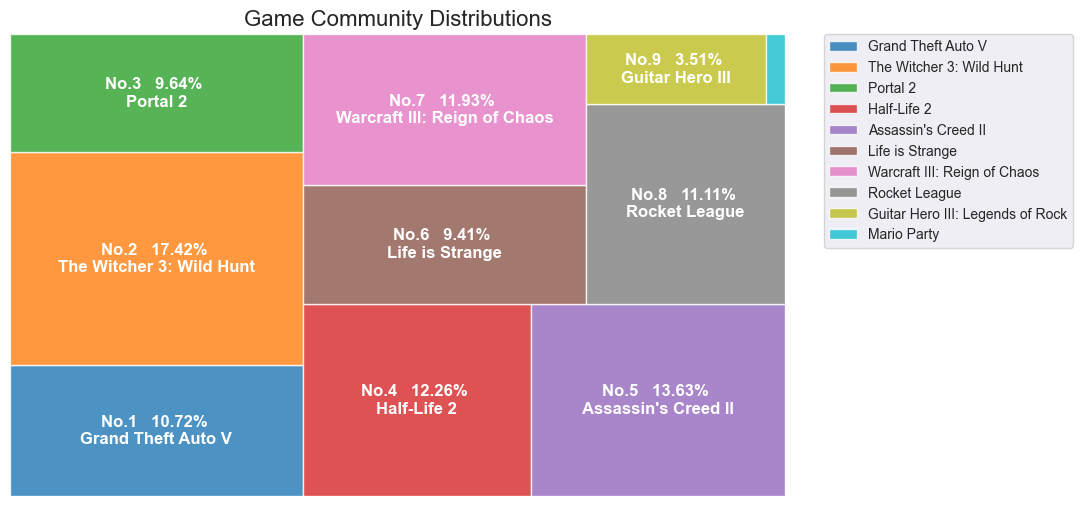

In [88]:
# small adjust
sign=labels.copy()
sign[-1]=""
sign[-2]=sign[-2][:15]

for i in range(len(sign)-1):
    sign[i]=str(f"No.{i+1}  ") + str(f" {(values[i] / sum(values)*100):.2f}% \n")+str(sign[i])

fig = plt.figure(figsize=(10, 6))
squarify.plot(
    sizes=values,
    label=sign,
    alpha=0.8,  # 透明度
    color=plt.cm.tab10(range(len(values))),
    text_kwargs={'fontsize': 12, 'color': 'white', 'weight': 'bold'})
plt.axis("off")  # 隐藏坐标轴
plt.title("Game Community Distributions", fontsize=16)
plt.legend(labels=labels,loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.savefig("treemap.png", dpi=400, bbox_inches="tight")
plt.show()


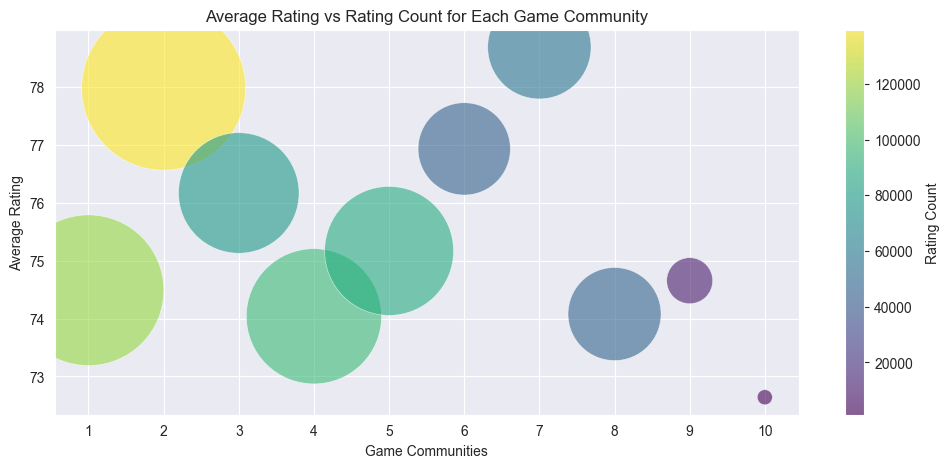

In [126]:
import matplotlib.pyplot as plt

bubble_sizes = [count / 10 for count in review_counts]
plt.figure(figsize=(12, 5))
# creat bubble chart
plt.scatter([i for i in range(1,11)], average_scores, s=bubble_sizes, alpha=0.6, c=review_counts, cmap='viridis', edgecolors="w", linewidth=0.5)

plt.xticks([i for i in range(1,11)])

plt.xlabel('Game Communities')
plt.ylabel('Average Rating')
plt.title('Average Rating vs Rating Count for Each Game Community')


plt.colorbar(label='Rating Count')
plt.savefig("bubble.png", dpi=400, bbox_inches="tight")
plt.show()


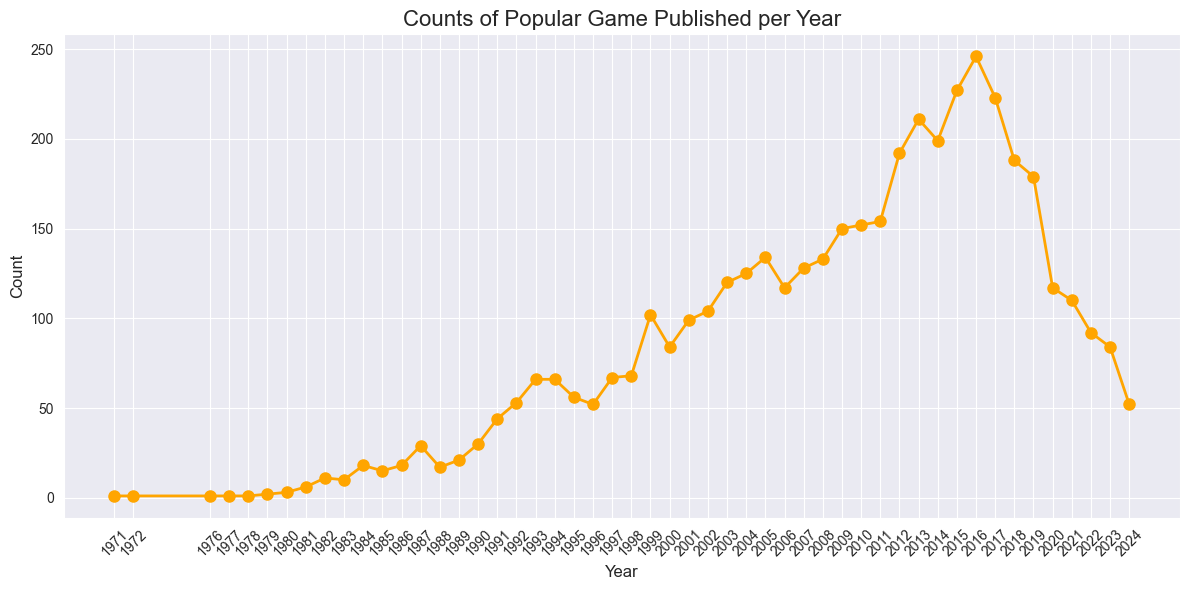

In [125]:
date = pd.to_datetime(df["first_release_date"], unit='s')
time_list=date.dt.year
yearly_counts = time_list.value_counts().sort_index()

plt.figure(figsize=(12, 6))
yearly_counts.plot(kind='line', marker='o', color='orange', linestyle='-', linewidth=2, markersize=8)

plt.xticks(yearly_counts.index)
plt.title('Counts of Popular Game Published per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)  # 添加网格线，便于观察趋势
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("line.png", dpi=400, bbox_inches="tight")

plt.show()

In [117]:
yearly_counts

first_release_date
1971      1
1972      1
1976      1
1977      1
1978      1
1979      2
1980      3
1981      6
1982     11
1983     10
1984     18
1985     15
1986     18
1987     29
1988     17
1989     21
1990     30
1991     44
1992     53
1993     66
1994     66
1995     56
1996     52
1997     67
1998     68
1999    102
2000     84
2001     99
2002    104
2003    120
2004    125
2005    134
2006    117
2007    128
2008    133
2009    150
2010    152
2011    154
2012    192
2013    211
2014    199
2015    227
2016    246
2017    223
2018    188
2019    179
2020    117
2021    110
2022     92
2023     84
2024     52
Name: count, dtype: int64